In [1]:
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE" # on NERSC filelocking is not allowed
import h5py
import tensorflow.keras as keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import pickle as pkl

import tensorflow as tf
# Make notebook run on other GPUS. GPT's solution ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
gpus = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[0], 'GPU')  # change 1 to 0, 2, 3 as needed
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

import sys
# Path to dir model.py lives in -------
# NOTE: This needs to be modified to where your repo lives, path to /repo/path/VAE_FS/models/
# If the jupyter notebook kernel is running from VAE_FS/models/ the
# line below is not needed
sys.path.append('/global/homes/j/jananinf/projs/VAE_FS/models/')

# import the custom models and functions
from models import VAE_Model, Qmake_encoder_set_weights, Qmake_decoder_set_weights
# in VAE_0 we are using the beta cyclical annealing from Kenny's repo

2025-07-10 16:29:32.767174: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-10 16:29:36.089232: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Load data
home_path = "/global/cfs/cdirs/m2616/jananinf/projsIO/VAE_FS/" # Updated to NERSC
file_path = home_path + "preprocessed_SNL_data.h5"
with h5py.File(file_path, 'r') as hf:           # Shapes:
    X_train = hf['X_train'][:]                  # (3200000, 57)
    X_test  = hf['X_test'][:]                   # (800000,  57)
    Ato4l_data  = hf['Ato4l_data'][:]           # (55969,   57) Signal data 
    hToTauTau_data  = hf['hToTauTau_data'][:]   # (691283,  57) ""
    hChToTauNu_data  = hf['hChToTauNu_data'][:] # (760272,  57) ""
    leptoquark_data = hf['leptoquark_data'][:]  # (340544,  57) ""
    print("Data loaded from preprocessed_SNL_data.h5")

Data loaded from preprocessed_SNL_data.h5


In [3]:
INPUT_SZ = 57
H1_SZ = 32
H2_SZ = 16
LATENT_SZ = 3
NUM_EPOCHS = 100
BATCH_SIZE = 1024
STOP_PATIENCE = 15
LR_PATIENCE = 10

# enc = Qmake_encoder_set_weights(INPUT_SZ, H1_SZ, H2_SZ, LATENT_SZ)
# enc.summary()

In [4]:
# dec = Qmake_decoder_set_weights(INPUT_SZ, H1_SZ, H2_SZ, LATENT_SZ)
# dec.summary()

In [5]:
# steps_per_epoch = X_train.shape[0] // BATCH_SIZE
# vae = VAE_Model(enc, dec, steps_per_epoch=steps_per_epoch, cycle_length=10, min_beta=0.1, max_beta=0.8)
# opt = keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1000)
# vae.compile(optimizer=opt) # Not sure what weighted_mse is doing.



In [6]:
# # looks like early_stopping is needed for val_loss
# early_stopping = EarlyStopping(patience=STOP_PATIENCE, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=LR_PATIENCE, verbose=1)

In [ ]:
train = True
NUM_TRAIN = 30 # For now lets just try 30
save = True
SAVE_PATH = home_path+f"/VAE_trainings/attempt2/old_cyclical_beta/" # As of 7/10/25 should be synced with vae0_analysis
# Last save is in attempt 1. New save should go to attempt 2
# Attempt History. The original code for each folder should also be tied to the commits. 
# 0: no weighted MSE, no call_backs
# 1: adding ReduceLRonPlatueau and early_stopping and the test_step
# 2: /old_cylcical_beta/. now training multiple times. But other wise no different from previous. This is to differentiate between the old cyclical beta and the atlas beta schedule.
# Changed batch size to match paper's 1024

early_stopping = EarlyStopping(patience=STOP_PATIENCE, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=LR_PATIENCE, verbose=1)

# # ─── 1. Build tf.data.Dataset so batches stream from CPU → GPU ─────────────
# # BATCH_SIZE = 512           # whatever you were using
# AUTOTUNE   = tf.data.AUTOTUNE

# train_ds = (
#     tf.data.Dataset.from_tensor_slices(X_train)
#     .shuffle(buffer_size=len(X_train))
#     .batch(BATCH_SIZE)
#     .prefetch(AUTOTUNE)
# )

# val_ds = (
#     tf.data.Dataset.from_tensor_slices(X_train) # uses same array but TF keeps views
#     .skip(int(0.8 * len(X_train)))              # crude 80-20 split
#     .batch(BATCH_SIZE)
#     .prefetch(AUTOTUNE)
# )

for i in range(2):
    if train:
        tf.keras.backend.clear_session()

        print(f"TRAINING ITERATION {i} ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
        enc = Qmake_encoder_set_weights(INPUT_SZ, H1_SZ, H2_SZ, LATENT_SZ)
        dec = Qmake_decoder_set_weights(INPUT_SZ, H1_SZ, H2_SZ, LATENT_SZ)

        steps_per_epoch = X_train.shape[0] // BATCH_SIZE
        vae = VAE_Model(enc, dec, steps_per_epoch=steps_per_epoch, cycle_length=10, min_beta=0.1, max_beta=0.8)
        opt = keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1000)
        vae.compile(optimizer=opt)


        # history = vae.fit(
        #             train_ds,
        #             validation_data=val_ds,
        #             epochs=NUM_EPOCHS,
        #             callbacks=[early_stopping, reduce_lr],
        #             verbose=2
        #         )
        history = vae.fit(x=X_train, validation_split=0.2, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping,reduce_lr], shuffle=True)
        # Iterative training. 
        save_path = SAVE_PATH+f"n_{i}/" # As of 7/8/25. Should be synced with vae0_analysis
        if save:
            print(f"SAVING ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
            vae.save_weights(filepath=save_path, save_format='tf')

            # Now save the histories
            with open(save_path + f"training_history.pkl", 'wb') as f:
                pkl.dump(history.history, f)




TRAINING ITERATION 0 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



2025-07-10 16:31:26.556709: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38366 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:03:00.0, compute capability: 8.0


Epoch 1/100


2025-07-10 16:31:29.297835: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-07-10 16:31:29.619026: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fdd9ed9b2f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-07-10 16:31:29.619050: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2025-07-10 16:31:29.656582: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-10 16:31:29.732840: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8901
2025-07-10 16:31:29.918896: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the pro

2500/2500 [==============================] - 16s 5ms/step - loss: 1.2150 - reconstruction_loss: 0.7181 - kl_loss: 0.0655 - beta: 0.1560 - val_loss: 1.0483 - val_reconstruction_loss: 1.0010 - val_kl_loss: 0.0473 - val_beta: 0.1560 - lr: 1.0000e-04
Epoch 2/100
2500/2500 [==============================] - 12s 5ms/step - loss: 0.4165 - reconstruction_loss: 0.3668 - kl_loss: 0.0419 - beta: 0.2120 - val_loss: 0.9208 - val_reconstruction_loss: 0.8808 - val_kl_loss: 0.0400 - val_beta: 0.2120 - lr: 1.0000e-04
Epoch 3/100
2500/2500 [==============================] - 12s 5ms/step - loss: 0.3665 - reconstruction_loss: 0.3163 - kl_loss: 0.0318 - beta: 0.2681 - val_loss: 0.8408 - val_reconstruction_loss: 0.8078 - val_kl_loss: 0.0329 - val_beta: 0.2681 - lr: 1.0000e-04
Epoch 4/100
2500/2500 [==============================] - 11s 5ms/step - loss: 0.3178 - reconstruction_loss: 0.2837 - kl_loss: 0.0256 - beta: 0.3240 - val_loss: 0.7737 - val_reconstruction_loss: 0.7502 - val_kl_loss: 0.0235 - val_beta: 

Plot Loss vs epoch history.

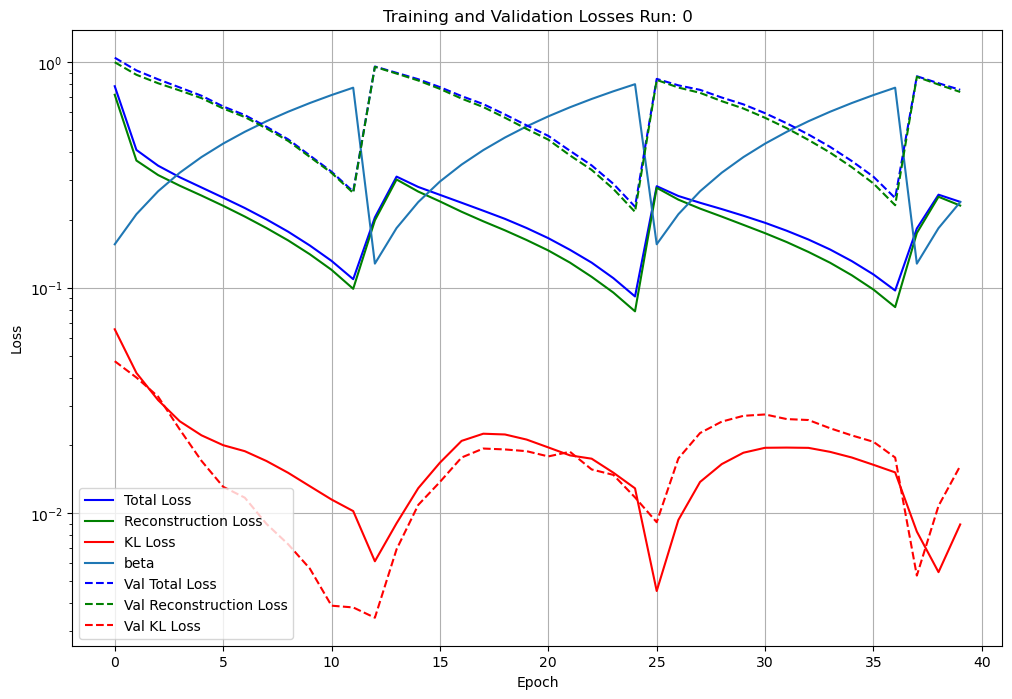

FileNotFoundError: [Errno 2] No such file or directory: '/global/cfs/cdirs/m2616/jananinf/projsIO/VAE_FS//VAE_trainings/attempt2/old_cyclical_beta/n_1/training_history.pkl'

In [8]:
import matplotlib.pyplot as plt
import pickle as pkl
# Assuming 'history' is the object returned by your model.fit() call

for i in range(NUM_TRAIN):
    save_path = SAVE_PATH + f"n_{i}/"
    with open(save_path + 'training_history.pkl', 'rb') as f:
        history = pkl.load(f)

    # Extract the loss values
    total_loss = history['loss']
    reco_loss = history['reconstruction_loss']
    kl_loss = history['kl_loss']
    val_total_loss = history['val_loss']
    val_reco_loss = history['val_reconstruction_loss']
    val_kl_loss = history['val_kl_loss']

    # Create a new figure
    plt.figure(figsize=(12, 8))

    # Plot training losses
    plt.plot(total_loss, label='Total Loss', color='blue')
    plt.plot(reco_loss, label='Reconstruction Loss', color='green')
    plt.plot(kl_loss, label='KL Loss', color='red')
    plt.plot(history['beta'],label="beta")

    # Plot validation losses
    plt.plot(val_total_loss, label='Val Total Loss', color='blue', linestyle='--')
    plt.plot(val_reco_loss, label='Val Reconstruction Loss', color='green', linestyle='--')
    plt.plot(val_kl_loss, label='Val KL Loss', color='red', linestyle='--')

    # Customize the plot
    plt.title(f'Training and Validation Losses Run: {i}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale("log")
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()